In [55]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pykalman import KalmanFilter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader



from model.early_stopping import EarlyStopping
from dataset.preparetion import generate_data
from dataset.travel_time_dataset import TravelTimeDataset

In [56]:
cfg = {
    'data': {
        'path': "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/1.csv",
        'feature': 'delta_t',
        'window_size': 6,
        'train_split_size': 0.6,
        'val_split_size': 0.2
    },
    'plots': {
        'show_plots': True,
        'color_actual': '#001F3F',
        'color_train': '#3D9970',
        'color_val': '#0074D9',
        'color_test': '#FF4136',
        'color_pred_train': '#3D9970',
        'color_pred_val': '#0074D9',
        'color_pred_test': '#FF4136',
    },
    'optimizer': {
        'name': 'adam',
        'lr': 0.001,
        'beta': (0.9, 0.999),
        'eps': 1e-8,
        'momentum': 0.9,
        'weight_decay': 1e-6,
    },
    'scheduler': {
        'step_size': 10,
    },
    'train': {
        'device': 'cuda',
        'batch_size': 4,
        'num_epoch': 200,
        'checkpoint_path': 'D:/Project/gps/checkpoints/lstm_kf',
    }
}

In [57]:
def download_data(cfg, plot):
    df = pd.read_csv(cfg['data']['path'], index_col=0, parse_dates=True)
    data_date = [date for date in df.index]
    data_date = np.array(data_date)
    data_date = data_date.reshape(-1, 1)
    
    data_travel_time = [float(df.loc[df.index == date][cfg['data']['feature']]) for date in df.index]
    data_travel_time = np.array(data_travel_time)
    data_travel_time = data_travel_time.reshape(-1, 1)

    num_data_points = len(data_date)
    print(f"Number data points: {num_data_points} from {data_date[0][0]} to {data_date[num_data_points - 1][0]}")
    
    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]
        
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_travel_time, color=cfg['plots']['color_actual']) 
        plt.title(f"Travel time of truck in road {road} and path {path}, from {data_date[0][0]} to {data_date[num_data_points - 1][0]}")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.show()

    return data_date, data_travel_time, num_data_points

Number data points: 7413 from 2019-01-01 00:00:00 to 2019-12-31 20:00:00


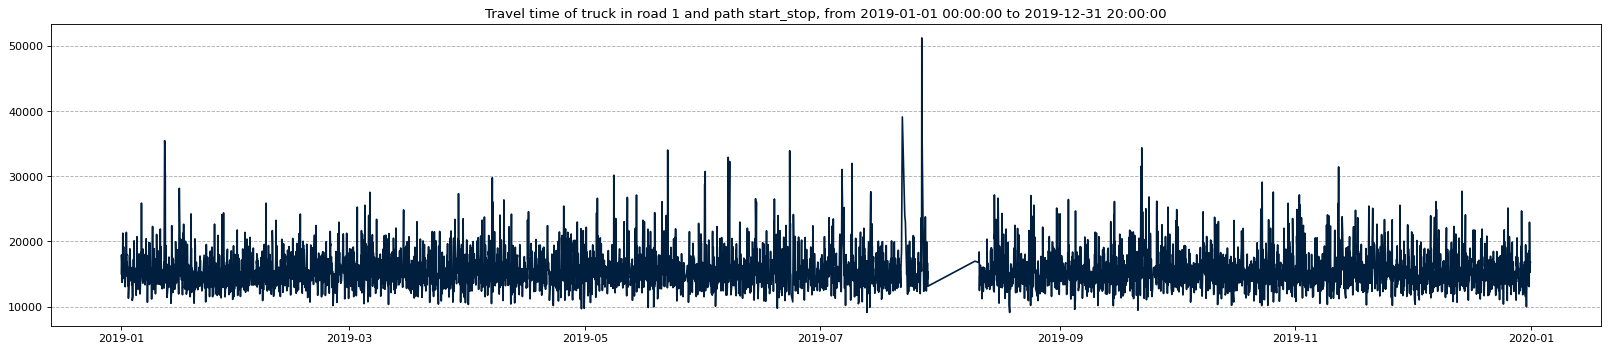

In [58]:
data_date, data_travel_time, num_data_points = download_data(cfg, cfg['plots']['show_plots'])

# Data preparation: normalize raw data

In [59]:
scaler = StandardScaler()
normalize_data_travel_time = scaler.fit_transform(data_travel_time)

# Kalman Filter

In [60]:
def kalmanFilter(test,test_predict):

    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
    kf = kf.em(test, n_iter=5, em_vars='all')
    test_predict_kf =(kf.smooth(test_predict)[0])[:, 0]

    #trainScore1 = math.sqrt(mean_squared_error(scaler.inverse_transform(test.reshape(1, -1)),scaler.inverse_transform(test_predict.reshape(1, -1))))
    mse1 = mean_squared_error(scaler.inverse_transform(test.reshape(1, -1)),scaler.inverse_transform(test_predict.reshape(1, -1)))
    rmse1 = math.sqrt(mean_squared_error(scaler.inverse_transform(test.reshape(1, -1)),scaler.inverse_transform(test_predict.reshape(1, -1))))
    mae1 = mean_absolute_error(scaler.inverse_transform(test.reshape(1, -1)),scaler.inverse_transform(test_predict.reshape(1, -1)))

    #trainScore2 = math.sqrt(mean_squared_error(scaler.inverse_transform(test.reshape(1, -1)),scaler.inverse_transform(test_predict_kf.reshape(1, -1))))
    mse2 = mean_squared_error(scaler.inverse_transform(test.reshape(1, -1)),scaler.inverse_transform(test_predict_kf.reshape(1, -1)))
    rmse2 = math.sqrt(mean_squared_error(scaler.inverse_transform(test.reshape(1, -1)),scaler.inverse_transform(test_predict_kf.reshape(1, -1))))
    mae2 = mean_absolute_error(scaler.inverse_transform(test.reshape(1, -1)),scaler.inverse_transform(test_predict_kf.reshape(1, -1)))

    #plot
    fig = plt.figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(scaler.inverse_transform(test.reshape(-1, 1)), label='Actual travel time', color=cfg['plots']['color_actual'])
    plt.plot(scaler.inverse_transform(test_predict.reshape(-1, 1)), label='Predicted travel time (test)', color=cfg['plots']['color_pred_test'])
    plt.plot(scaler.inverse_transform(test_predict_kf.reshape(-1, 1)), label="Improved predicted travel time (test)", color=cfg['plots']['color_pred_train'])

    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    print('Score Before Kalman Filtering: ')
    print(f"MSE : {mse1} || RMSE : {rmse1} || MAE : {mae1}")
    print(f"==================================================================================")
    print('Score After Kalman Filtering: ')
    print(f"MSE : {mse2} || RMSE : {rmse2} || MAE : {mae2}")
    print(f"==================================================================================")
    
    return test_predict_kf.reshape(-1, 1)

# Data preparation: generating training, test and validation data

In [61]:
def split_data_time_over(period, data_date, data_travel_time, num_data_points):
    time = [[]] * (21//period)
    travel_time = [[]] * (21//period)
    num_data_points_list = []

    for part_time_idx in range(21//period):
        for idx in range(num_data_points//21):
            time[part_time_idx] = time[part_time_idx] + data_date[(idx * 21) + (part_time_idx * period):(idx * 21) + period + (part_time_idx * period)].tolist()
            travel_time[part_time_idx] = travel_time[part_time_idx] + data_travel_time[(idx * 21) + (part_time_idx * period):(idx * 21) + period + (part_time_idx * period)].tolist()

        time[part_time_idx] = np.array(time[part_time_idx])
        travel_time[part_time_idx] = np.array(travel_time[part_time_idx])
        num_data_points_list.append(len(time[part_time_idx]))
    return time, travel_time, num_data_points_list

In [62]:
time, travel_time, num_data_points_list = split_data_time_over(21, data_date, normalize_data_travel_time, num_data_points)

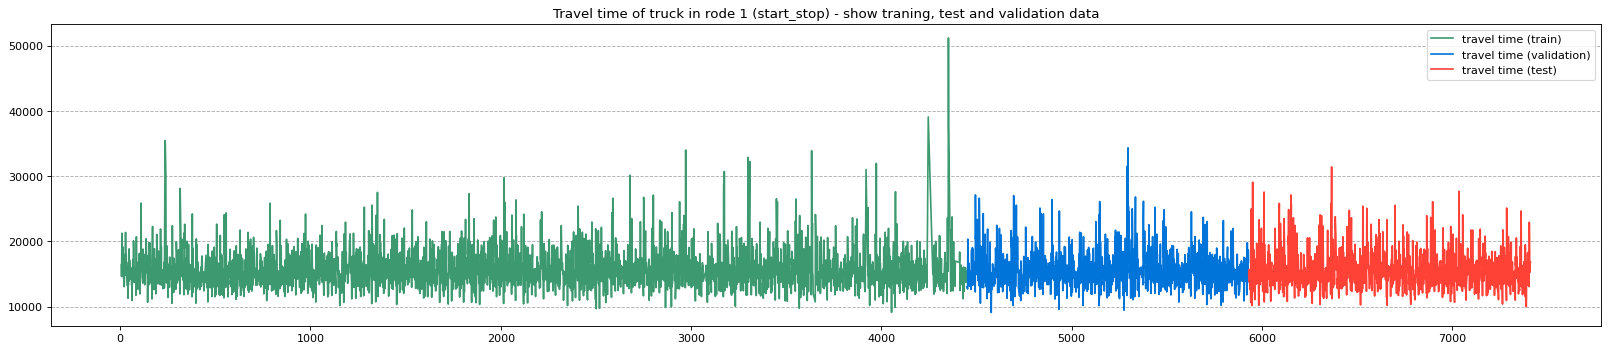

In [63]:
data_x_train_list, data_x_val_list, data_x_test_list, data_y_train_list, data_y_val_list, data_y_test_list, split_val_index_list = [], [], [], [], [], [], []
for idx in range(len(time)):
    data_x_train, data_x_val, data_x_test, data_y_train, data_y_val, data_y_test, _, split_val_index = generate_data(travel_time[idx], time[idx], num_data_points_list[idx], scaler, cfg, True)
    data_x_train_list.append(data_x_train)
    data_x_val_list.append(data_x_val)
    data_x_test_list.append(data_x_test)
    data_y_train_list.append(data_y_train)
    data_y_val_list.append(data_y_val)
    data_y_test_list.append(data_y_test)
    split_val_index_list.append(split_val_index)

In [64]:
for idx in range(len(data_x_train_list)):
    print(f"time: {idx}")
    print(f"Train data shape: {data_x_train_list[idx].shape} {data_y_train_list[idx].shape}")
    print(f"Validation data shape: {data_x_val_list[idx].shape} {data_y_val_list[idx].shape}")
    print(f"Test data shape: {data_x_test_list[idx].shape} {data_y_test_list[idx].shape}")

time: 0
Train data shape: (4444, 6) (4444,)
Validation data shape: (1481, 6) (1481,)
Test data shape: (1482, 6) (1482,)


In [65]:
data_x_train_list[idx]

array([[-0.25109493,  0.75347566,  0.50314129,  0.25280692,  0.17290314,
        -0.70190464],
       [ 0.75347566,  0.50314129,  0.25280692,  0.17290314, -0.70190464,
         0.23594861],
       [ 0.50314129,  0.25280692,  0.17290314, -0.70190464,  0.23594861,
        -0.38965639],
       ...,
       [-0.49138359, -0.0052869 ,  0.06915525, -0.71181178, -0.53739754,
        -0.3691031 ],
       [-0.0052869 ,  0.06915525, -0.71181178, -0.53739754, -0.3691031 ,
        -0.10278468],
       [ 0.06915525, -0.71181178, -0.53739754, -0.3691031 , -0.10278468,
        -0.10023614]])

In [66]:
dataset_train, dataset_val, dataset_test = [], [], []
for idx in range(len(data_x_train_list)):
    dataset_train.append(TravelTimeDataset(data_x_train_list[idx], data_y_train_list[idx]))
    dataset_val.append(TravelTimeDataset(data_x_val_list[idx], data_y_val_list[idx]))
    dataset_test.append(TravelTimeDataset(data_x_test_list[idx], data_y_test_list[idx]))
    print(f"time : {idx}")
    print(f"Train data for model shape: {dataset_train[idx].x.shape} {dataset_train[idx].y.shape}")
    print(f"Validation data for model shape: {dataset_val[idx].x.shape} {dataset_val[idx].y.shape}")
    print(f"Test data for model shape: {dataset_test[idx].x.shape} {dataset_test[idx].y.shape}")

time : 0
Train data for model shape: (4444, 1, 6) (4444,)
Validation data for model shape: (1481, 1, 6) (1481,)
Test data for model shape: (1482, 1, 6) (1482,)


# Define LSTM model

In [67]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=2, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[2], x.shape[1])
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)

        return out

In [68]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

# Model training

In [69]:
def train(dataset_train, dataset_val, model, cfg, idx, count):
    # init tool for train model
    # craete dataloader
    train_dataloader = DataLoader(dataset_train, batch_size=cfg['train']['batch_size'], shuffle=True)
    val_dataloader = DataLoader(dataset_val, batch_size=cfg['train']['batch_size'], shuffle=True)

    # define optimizer, sheduler and loss function
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg['optimizer']['lr'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg['scheduler']['step_size'], gamma=0.5)
    early_stopping = EarlyStopping(patience=20, verbose=True, path=cfg['train']['checkpoint_path'])

    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    
    for epoch in range(cfg['train']['num_epoch']):
        print(f"Epoch: {epoch + 1}")

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (x, y) in enumerate(train_dataloader):
            batch_size = x.shape[0]

            x = x.to(cfg['train']['device'])
            y = y.to(cfg['train']['device'])
            
            # prediction
            pred = model(x.float())
            loss = criterion(pred[:,0], y.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # add train loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (x, y) in enumerate(val_dataloader):
            batch_size = x.shape[0]

            x = x.to(cfg['train']['device'])
            y = y.to(cfg['train']['device'])

            pred = model(x.float())
            loss = criterion(pred[:,0], y.float())

            # add valid loss
            valid_losses.append(loss.item())

        # update scheduler
        lr = scheduler.get_last_lr()[0]
        scheduler.step()

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        print(f"[Epoch: {epoch + 1} / {cfg['train']['num_epoch']} || train_loss: {train_loss:.5f} || valid_loss: {valid_loss:.5f} || lr: {lr:.5f}]")

        train_losses = []
        valid_losses = []

        early_stopping(valid_loss, epoch, model, cfg, idx, count)

        if early_stopping.early_stop:
            # print('Early stopping')
            break

    return avg_train_losses, avg_valid_losses, early_stopping, model

# Model evaluation

In [70]:
def eval(dataset_test, split_val_index, data_date, scaler, model, cfg, best_model_name, plot=False):
    # init tool for train model
    # craete dataloader
    test_dataloader = DataLoader(dataset_test, batch_size=cfg['train']['batch_size'], shuffle=False)

    checkpoint = torch.load(os.path.join(cfg['train']['checkpoint_path'], best_model_name + '.pth'))
    model.load_state_dict(checkpoint['net'])

    predicted_test = np.array([])

    model.eval()
    for batch_idx, (x, y) in enumerate(test_dataloader):
        x = x.to(cfg['train']['device'])
        pred = model(x.float())
        pred = pred.cpu().detach().numpy()
        predicted_test = np.concatenate((predicted_test, pred[:, 0]))

    mse = mean_squared_error(scaler.inverse_transform(dataset_test.y.reshape(1, -1)), scaler.inverse_transform(predicted_test.reshape(1, -1)))
    rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(dataset_test.y.reshape(1, -1)), scaler.inverse_transform(predicted_test.reshape(1, -1))))
    mae = mean_absolute_error(scaler.inverse_transform(dataset_test.y.reshape(1, -1)), scaler.inverse_transform(predicted_test.reshape(1, -1)))


    kalmanFilter(dataset_test.y,predicted_test)
   

    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]

        to_plot_data_y_test_subset = scaler.inverse_transform(dataset_test.y.reshape(-1, 1))
        to_plot_predicted_test = scaler.inverse_transform(predicted_test.reshape(-1, 1))
        to_plot_data_date = data_date[split_val_index + cfg['data']['window_size']:]

        idx = np.arange(0, len(data_date[split_val_index + cfg['data']['window_size']:]))

        #plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(idx, to_plot_data_y_test_subset, label='Actual travel time', color=cfg['plots']['color_actual'])
        plt.plot(idx, to_plot_predicted_test, label='Predicted travel time (test)', color=cfg['plots']['color_pred_test'])
        plt.title(f"Examine predicted travel time on test data portion of road {road} ({path}) [MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f}]")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return mse, rmse, mae

# Modified

Epoch: 1
[Epoch: 1 / 200 || train_loss: 0.87461 || valid_loss: 0.80756 || lr: 0.00100]
Validation loss decreased (inf --> 0.807560). Saving model ...
Epoch: 2
[Epoch: 2 / 200 || train_loss: 0.80683 || valid_loss: 0.79957 || lr: 0.00100]
Validation loss decreased (0.807560 --> 0.799571). Saving model ...
Epoch: 3
[Epoch: 3 / 200 || train_loss: 0.79377 || valid_loss: 0.78637 || lr: 0.00100]
Validation loss decreased (0.799571 --> 0.786372). Saving model ...
Epoch: 4
[Epoch: 4 / 200 || train_loss: 0.78903 || valid_loss: 0.79693 || lr: 0.00100]
Epoch: 5
[Epoch: 5 / 200 || train_loss: 0.77455 || valid_loss: 0.79080 || lr: 0.00100]
Epoch: 6
[Epoch: 6 / 200 || train_loss: 0.76914 || valid_loss: 0.80804 || lr: 0.00100]
Epoch: 7
[Epoch: 7 / 200 || train_loss: 0.76115 || valid_loss: 0.78727 || lr: 0.00100]
Epoch: 8
[Epoch: 8 / 200 || train_loss: 0.76344 || valid_loss: 0.77629 || lr: 0.00100]
Validation loss decreased (0.786372 --> 0.776287). Saving model ...
Epoch: 9
[Epoch: 9 / 200 || train_los

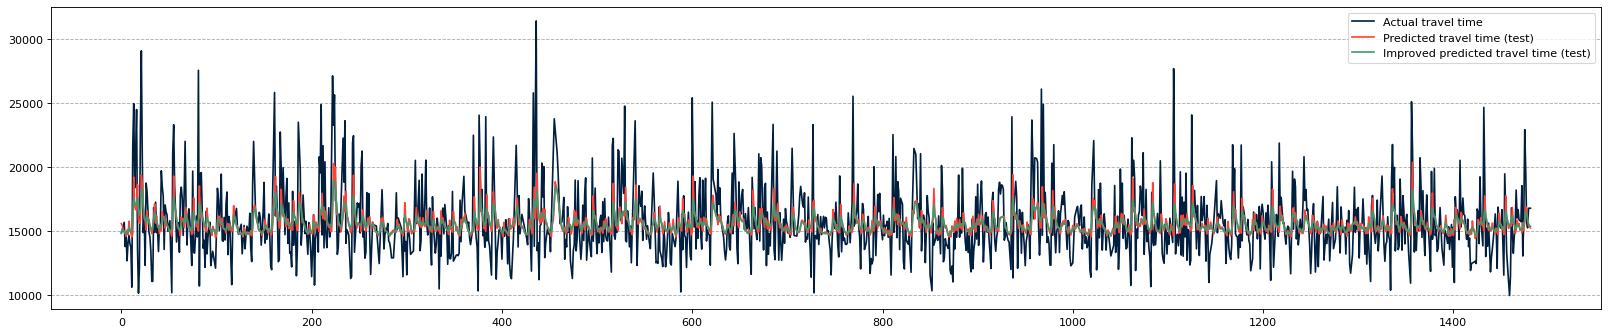

Score Before Kalman Filtering: 
MSE : 6771846.304274647 || RMSE : 2602.2771382530814 || MAE : 1907.9262948240864
Score After Kalman Filtering: 
MSE : 6339167.679318661 || RMSE : 2517.770378592667 || MAE : 1856.8295255889532


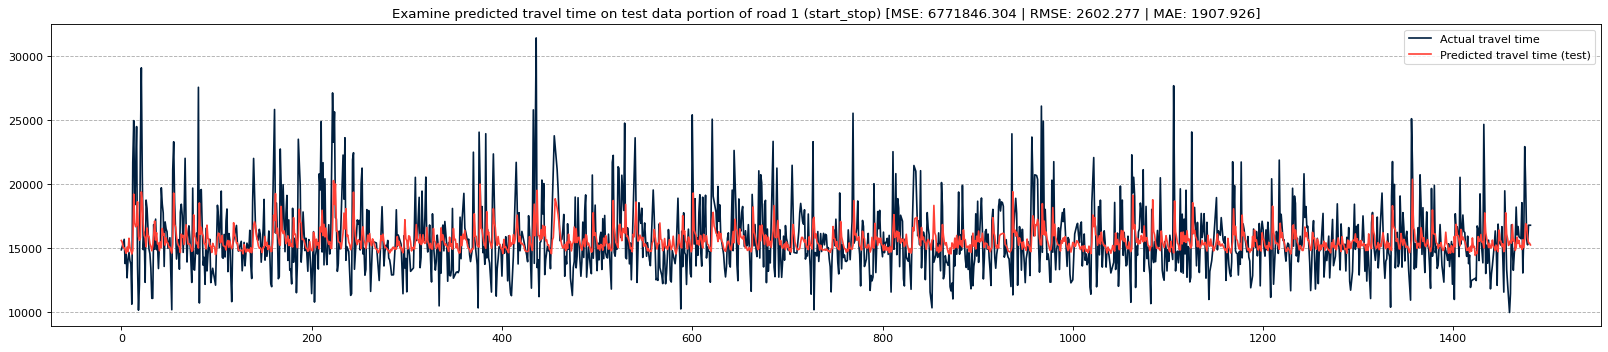

time : 0
MSE : 6771846.304274647 || RMSE : 2602.2771382530814 || MAE : 1907.9262948240864


In [71]:
result = []
for idx in range(len(dataset_train)):
    model = LSTM() #change to lSTM
    model.apply(init_weights)
    if torch.cuda.is_available():
        cfg['train']['device'] = 'cuda'
    else:
        cfg['train']['device'] = 'cpu'
    model = model.to(cfg['train']['device'])

    train_losses, valid_losses, early_stopping, model = train(dataset_train[idx], dataset_val[idx], model, cfg, idx, 0)

    mse, rmse, mae = eval(dataset_test[idx], split_val_index_list[idx], time[idx], scaler, model, cfg, f"lstm_time_{idx}_{0}", True)

    print(f"time : {idx}")
    print(f"MSE : {mse} || RMSE : {rmse} || MAE : {mae}")
    print(f"==================================================================================")

    result.append({
        'name': f"time-{idx}",
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
    })